# Lecture 10: Clustering

For this lecture, we are going to dive deeper into another application area of unsupervised learning, clustering.

# 10.1. Gaussian Mixture Models for Clustering

Clustering is a common unsupervised learning problem with numerous applications.

We will start by defining the problem and outlining some models for this problem.

## 10.1.1. Review: Unsupervised Learning

We have a dataset *without* labels. Our goal is to learn something interesting about the structure of the data:

* Clusters hidden in the dataset.

* Outliers: particularly unusual and/or interesting datapoints.

* Useful signal hidden in noise, e.g. human speech over a noisy phone.

## 10.1.2. Clustering

Clustering is the problem of identifying distinct components in the data. Usually, we apply clustering when we assume that the data will have a certain structure, specifically:

<!-- * A cluster $C_k \subseteq \mathcal{X}$ can be thought of as a subset of the space $\mathcal{X}$. -->
* Datapoints in a cluster are more similar to each other than to points in other clusters

* Clusters are usually defined by their centers, and potentially by other shape parameters.

## 10.1.3. Review: $K$-Means

$K$-Means is the simplest example of a clustering algorithm.
Starting from random centroids, we repeat until convergence:

1. Update each cluster: assign each point to its closest centroid.

2. Set each centroid to be the center of its cluster.

This is best illustrated visually - see [Wikipedia](https://commons.wikimedia.org/wiki/File:K-means_convergence.gif)

$K$-Means has a number of limitations:

* Clustering can get stuck in local minima

* Measuring clustering quality is hard and relies on heuristics

* Cluster assignment is binary and doesn't estimate confidence

# 10.1.4. Review: Density Estimation

An unsupervised probabilistic model is a probability distribution
$$P_\theta(x) : \mathcal{X} \to [0,1].$$
Probabilistic models often have *parameters* $\theta \in \Theta$.

The task of density estimation is to learn a $P_\theta$ on an unsupervised dataset $\mathcal{D}$ to approximate the true data distribution $P_\text{data}$.

We will use density estimation for clustering; first, we need a model $P_\theta$.

# 10.1.5. Gaussian Mixture Models (GMM)

Gaussian mixtures define a model of the form:
$$P_\theta (x,z) = P_\theta (x | z) P_\theta (z)$$

* $z \in \mathcal{Z} = \{1,2,\ldots,K\}$ is discrete and follows a categorical distribution $P_\theta(z=k) = \phi_k$.

* $x \in \mathbb{R}$ is continuous; conditioned on $z=k$, it follows a Normal distribution $P_\theta(x | z=k) = \mathcal{N}(\mu_k, \Sigma_k)$.

The parameters $\theta$ are the $\mu_k, \Sigma_k, \phi_k$ for all $k=1,2,\ldots,K$.

The model postulates that:

* Our observed data is comprised of  $K$ clusters with proportions specified by $\phi_1,\phi_2, \ldots, \phi_K$

* The points within each cluster follow a Normal distribution $P_\theta(x | z=k) = \mathcal{N}(\mu_k, \Sigma_k)$.

With this structure, $z^{(i)}$ is the cluster label for data point $x^{(i)}$ and can be obtained from $P(z^{(i)}|x^{(i)})$

And to get the marginal distribution $P_\theta (x)$, we can sum over the joint distribution as follows:

\begin{align}
P_\theta (x) 
& = \sum_{k=1}^K P_\theta (z=k) P_\theta (x|z=k)\\
& = \phi_1 \mathcal{N}(x; \mu_1, \Sigma_1)  +  \ldots + \phi_K \mathcal{N}(x; \mu_K, \Sigma_K)
\end{align}

## 10.1.6. Clustering With Known Cluster Assignments

Let's first think about how we would do clustering if the identity of each cluster is known.

Specifically, let our dataset be $\mathcal{D} = \{(x^{(1)}, z^{(1)}), (x^{(2)}, z^{(2)}), \ldots, (x^{(n)}, z^{(n)})\}$

* $x^{(i)} \in \mathbb{R}$ are the datapoints we cluster

* $z^{(i)} \in \{1,2,...,K\}$ are the cluster IDs

* We want to fit a GMM, where $\mu_k$ represent the cluster centroids.

How could we do this?

This is the same problem as in Gaussian Discriminant Analysis (GDA). We can fit a GMM to this data as follows:

1. We fit the parameters $\phi_k$ to be % of each class $k$ in $\mathcal{D}$.

2. We fit the parameters $\mu_k, \Sigma_k$ to be means and variances of each class $k$.

3. We can infer the cluster ID $z$ of new points using $P(z|x)$ as in GDA.

Let's look at an example on our Iris flower dataset. Below, we load the dataset:

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn import datasets

# Load the Iris dataset
iris = datasets.load_iris(as_frame=True)

# print part of the dataset
iris_X, iris_y = iris.data, iris.target
pd.concat([iris_X, iris_y], axis=1).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Recall that we have previously seen how to fit GMMs on a labeled $(x,y)$ dataset using maximum likelihood.

Let's try this on our Iris dataset again (recall that this is called GDA). Below, we estimate/fit the parameters of GMM:

In [3]:
# we can implement these formulas over the Iris dataset
X = iris_X.to_numpy()[:,:2]
d = 2 # number of features in our toy dataset
K = 3 # number of clases
n = X.shape[0] # size of the dataset

# these are the shapes of the parameters
mus = np.zeros([K,d])
Sigmas = np.zeros([K,d,d])
phis = np.zeros([K])

# we now compute the parameters
for k in range(3):
    X_k = X[iris_y == k]
    mus[k] = np.mean(X_k, axis=0)
    Sigmas[k] = np.cov(X_k.T)
    phis[k] = X_k.shape[0] / float(n)

The code below generates predictions from the GMM model that we just learned by implementing Bayes' rule:

In [5]:
# we can implement this in numpy
def gda_predictions(x, mus, Sigmas, phis):
    """This returns class assignments and p(y|x) under the GDA model.
    
    We compute \arg\max_y p(y|x) as \arg\max_y p(x|y)p(y)
    """
    # adjust shapes
    n, d = x.shape
    x = np.reshape(x, (1, n, d, 1))
    mus = np.reshape(mus, (K, 1, d, 1))
    Sigmas = np.reshape(Sigmas, (K, 1, d, d))    
    
    # compute probabilities
    py = np.tile(phis.reshape((K,1)), (1,n)).reshape([K,n,1,1])
    pxy = (
        np.sqrt(np.abs((2*np.pi)**d*np.linalg.det(Sigmas))).reshape((K,1,1,1)) 
        * -.5*np.exp(
            np.matmul(np.matmul((x-mus).transpose([0,1,3,2]), np.linalg.inv(Sigmas)), x-mus)
        )
    )
    pyx = pxy * py
    return pyx.argmax(axis=0).flatten(), pyx.reshape([K,n])

idx, pyx = gda_predictions(X, mus, Sigmas, phis)

We can visualize the GMM as follows:

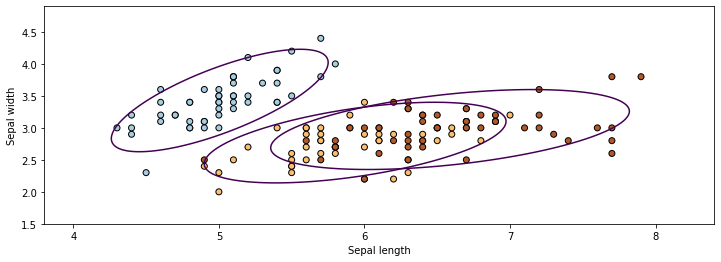

In [10]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [12, 4]

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z, pyx = gda_predictions(np.c_[xx.ravel(), yy.ravel()], mus, Sigmas, phis)
logpy = np.log(-1./3*pyx)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
contours = np.zeros([K, xx.shape[0], xx.shape[1]])
for k in range(K):
    contours[k] = logpy[k].reshape(xx.shape)
for k in range(K):
    plt.contour(xx, yy, contours[k], levels=np.logspace(0, 1, 1))

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=iris_y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.show()

In the figure above, the ellipses represent the Gaussians, while the dots with different colors are the datapoints belonging to different classes.

In the above example, the $P_\theta(z|x)$ from the GMM $P_\theta$ tells us the cluster ID $z$ of $x$. We straightforwardly trained the GMM $P_\theta$ by maximizing likelihood since we know the label of each datapoint, i.e., which cluster it belongs to.

But what if we don't have labels to train $P_\theta$?

## 10.1.7. From Labeled to Unlabeled Clustering

We will now talk about how to train a GMM clustering model from unlabeled data.

Our strategy will be to jointly learn cluster parameters and labels:

1. We will define an objective that does not require cluster labels $z^{(i)}$.
2. We will define an optimizer that jointly infers both labels $z^{(i)}$ and cluster parameters $\mu_k, \Sigma_k$.

### 10.1.7.1. Maximum Marginal Likelihood Learning

Maximum marginal (log-)likelihood is a way of learning a probabilistic model on an unsupervised dataset $\mathcal{D}$ by maximizing:
$$
\frac{1}{n}\sum_{i=1}^n \log P_\theta({x}^{(i)}) = \frac{1}{n}\sum_{i=1}^n \log \left(\sum_{z \in \mathcal{Z}} P_\theta({x}^{(i)}, z)\right).
$$

* This asks $P_\theta$ to assign a high probability to the training data in $\mathcal{D}$.

* However, we need to use $P(x) = \sum_{z \in \mathcal{Z}} P(x,z)$ to compute this probability because $z$ is not observed.

Since our objective is
$$\max_\theta \frac{1}{n}\sum_{i=1}^n \log \left(\sum_{z \in \mathcal{Z}} P_\theta({x}^{(i)}, z)\right)$$

* Our intuition of assigning high probability to data still holds

* $z$ encodes the cluster id; we ask $P_\theta$ to be high for *at least one $z$*

* We are  still minimizing KL divergence between $P_\theta$ and $P_\text{data}$

Recall that the Kullback-Leibler (KL) divergence $D(\cdot\|\cdot)$ between the model distribution and the data distribution is:
$$
D(P_\text{data} \| P_\theta) = \sum_{{\bf x}} P_\text{data}({\bf x}) \log \frac{P_\text{data}({\bf x})}{P_\theta({\bf x})}.
$$

The KL divergence is always non-negative, and equals zero when $P_\text{data}$ and $P_\theta$ are identical. This makes it a natural measure of similarity that's useful for comparing distributions. 

How do we optimize the marginal likelihood objective? Optimizing the likelihood of mixture models is harder than optimizing the likelihood of single gaussian models. For mixture models, there are no closed form solutions, and unlike a single Gaussian, a mixture has many local maxima. We will talk about an algorithm to train mixture models later in this lecture

### 10.1.7.2. Recovering Clusters from GMMs

Given a trained GMM model $P_\theta (x,z) = P_\theta (x | z) P_\theta (z)$, it's easy to compute the *posterior* probability

$$P_\theta(z = k\mid x) = \frac{P_\theta(z=k, x)}{P_\theta(x)} = \frac{P_\theta(x | z=k) P_\theta(z=k)}{\sum_{l=1}^K P_\theta(x | z=l) P_\theta(z=l)}$$

of a point $x$ belonging to class $k$.

* The posterior defines a "soft" assignment of $x$ to each class.

* This is in contrast to the hard assignments from $K$-Means.

## 10.1.8. Beyond Gaussian Mixtures

We will focus on Gaussian mixture models in this lecture, but there exist many other kinds of clustering:

* Hierarchical clusters

* Points belonging to multiple clusters (e.g. topics)

* Clusters in graphs


See the `scikit-learn` [guide](https://scikit-learn.org/stable/modules/clustering.html) for more!

# 10.2. Expectation Maximization

Recall the issues we had earlier with trying to perform unlabeled clustering with Gaussian mixture models:

* Unlike in supervised learning, cluster assignments are latent.

* Hence, there is not a closed form solution for $\theta$. 

We will now introduce expectation maximization (EM), an algorithm that can be used to fit Gaussian mixture models.

## 10.2.1. Expectation Maximization: Intuition

Expectation maximization (EM) is an algorithm for maximizing marginal log-likelihood 
$$\max_\theta \sum_{x^{(i)}\in \mathcal{D}} \log \left( \sum_{z \in \mathcal{Z}}P_\theta(x^{(i)}, z) \right)$$
that can also be used to learn Gaussian mixtures.

The idea behind expectation maximization is:

* If we know the true $z^{(i)}$ for each $x^{(i)}$, we maximize
$$\max_\theta \sum_{x^{(i)}, z^{(i)}\in \mathcal{D}} \log \left( P_\theta(x^{(i)}, z^{(i)}) \right).$$ 
and it's easy to find the best $\theta$ (use solution for supervised learning).

* If we know $\theta$, we can estimate the cluster assignments $z^{(i)}$ for each $i$ by computing $P_\theta(z | x^{(i)})$.

Expectation maximization alternates between these two steps.

1. (__E-Step__) Given an estimate $\theta_t$ of the weights, compute $P_\theta(z | x^{(i)})$.
and use it to “hallucinate” expected cluster assignments $z^{(i)}$.

2. (__M-Step__) Find a new $\theta_{t+1}$ that maximizes the marginal log-likelihood by optimizing $P_\theta(x^{(i)}, z^{(i)})$ given the $z^{(i)}$ from step 1.

This process increases the marginal likelihood at each step and eventually converges.

## 10.2.2. Expectation Maximization: Definition

Formally, EM learns the parameters $\theta$ of a latent-variable model $P_\theta(x,z)$ over a dataset $\mathcal{D} = \{x^{(i)} \mid i = 1,2,...,n\}$ as follows.

For $t=0,1,2,\ldots$, repeat until convergence:
1. (__E-Step__) For each $x^{(i)} \in \mathcal{D}$ compute $P_{\theta_t}(z|x^{(i)})$

2. (__M-Step__) Compute new weights $\theta_{t+1}$ as
\begin{align*}
\theta_{t+1} & = \arg\max_{\theta} \sum_{i=1}^n \mathbb{E}_{z^{(i)} \sim P_{\theta_t}(z|x^{(i)})} \log P_{\theta}(x^{(i)}, z^{(i)}) \\
& = \arg\max_{\theta} \sum_{i=1}^n \sum_{k=1}^K P_{\theta_t}(z=k|x^{(i)}) \log P_{\theta}(x^{(i)}, z=k)
\end{align*}

Since assignments $P_{\theta_t}(z|x^{(i)})$ are "soft", M-step involves an expectation. For many interesting models, this expectation is tractable.

## 10.2.3. Pros and Cons of EM

EM is a very important optimization algorithm in machine learning.

* It is easy to implement and is guaranteed to converge.

* It works in a lot of important ML models.

Its limitations include:

* It can get stuck in local optima.

* We may not be able to compute $P_{\theta_t}(z|x^{(i)})$ in every model.

# 10.3. Expectation Maximization in Gaussian Mixture Models

Next, let's work through how Expectation Maximization works in Gaussian Mixture Models.

## 10.3.1. Deriving the E-Step

In the E-step, we compute the posterior for each data point $x$ as follows
 $$P_\theta(z = k\mid x) = \frac{P_\theta(z=k, x)}{P_\theta(x)} = \frac{P_\theta(x | z=k) P_\theta(z=k)}{\sum_{l=1}^K P_\theta(x | z=l) P_\theta(z=l)}$$
$P_\theta(z = k\mid x)$ defines a vector of probabilities that $x$ originates from component $k$ given the current set of parameters $\theta$

## 10.3.2. Deriving the M-Step

At the M-step, we optimize the expected log-likelihood of our model.

\begin{align*}
&\max_\theta \sum_{x \in D} \mathbb{E}_{z \sim P_{\theta_t}(z|x)} \log P_\theta(x,z) = \\
& \max_\theta \left( \sum_{k=1}^K \sum_{x \in D} P_{\theta_t}(z = k|x) \log P_\theta(x|z = k) + \sum_{k=1}^K \sum_{x \in D} P_{\theta_t}(z = k|x) \log P_\theta(z = k) \right)
\end{align*}

As in supervised learning, we can optimize the two terms above separately.

We will start with $P_\theta(x\mid z=k) = \mathcal{N}(x; \mu_k, \Sigma_k)$. We have to find $\mu_k, \Sigma_k$ that optimize
$$
\max_\theta \sum_{x^{(i)} \in D} P(z=k|x^{(i)}) \log P_\theta(x^{(i)}|z=k)
$$
Note that this corresponds to fitting a Gaussian to a dataset whose elements $x^{(i)}$ each have a weight $P(z=k|x^{(i)})$.

Similar to how we did this in the supervised regime, we compute the derivative, set it to zero, and obtain closed form solutions:
\begin{align*}
\mu_k & = \frac{\sum_{i=1}^n P(z=k|x^{(i)}) x^{(i)}}{n_k} \\
\Sigma_k & = \frac{\sum_{i=1}^n P(z=k|x^{(i)}) (x^{(i)} - \mu_k)(x^{(i)} - \mu_k)^\top}{n_k} \\
n_k & = \sum_{i=1}^n P(z=k|x^{(i)}) \\
\end{align*}
Intuitively, the optimal mean and covariance are the emprical mean and convaraince of the dataset $\mathcal{D}$ when each element $x^{(i)}$ has a weight $P(z=k|x^{(i)})$.

Similarly, we can show that the class priors are
\begin{align*}
\phi_k & = \frac{n_k}{n} \\
n_k & = \sum_{i=1}^n P(z=k|x^{(i)})
\end{align*}

## 10.3.3. Summary: EM in Gaussian Mixture Models

EM learns the parameters $\theta$ of a Gaussian mixture model $P_\theta(x,z)$ over a dataset $\mathcal{D} = \{x^{(i)} \mid i = 1,2,...,n\}$ as follows.

For $t=0,1,2,\ldots$, repeat until convergence:
1. (__E-Step__) For each $x^{(i)} \in \mathcal{D}$ compute $P_{\theta_t}(z|x^{(i)})$
2. (__M-Step__) Compute parameters $\mu_k, \Sigma_k, \phi_k$ using the above formulas

# 10.4. Generalization in Probabilistic Models

Let's now revisit the concepts of overfitting and underfitting in GMMs.

## 10.4.1. Review: Data Distribution

We will assume that the dataset is sampled from a probability distribution $\mathbb{P}$, which we will call the *data distribution*. We will denote this as
$$x \sim \mathbb{P}.$$

The dataset $\mathcal{D} = \{x^{(i)} \mid i = 1,2,...,n\}$ consists of *independent and identicaly distributed* (IID) samples from $\mathbb{P}$.

## 10.4.2. Underfitting and Overfitting

Consider the following dataset, which is generated from a mixture of four Gaussians. Below, we display 100 samples generated by the mixture distribution:

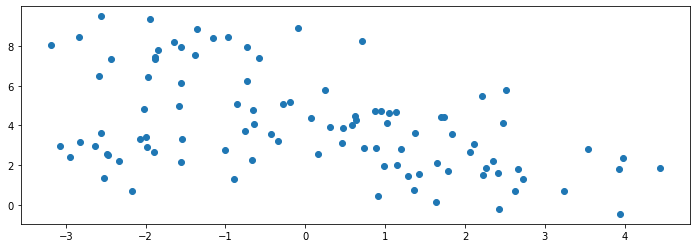

In [49]:
import numpy as np
from sklearn import datasets
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]

# generate 150 random points
np.random.seed(0)
X_all, y_all = datasets.make_blobs(150, centers=4)

# use the first 100 points as the main dataset
X, y = X_all[:100], y_all[:100]
plt.scatter(X[:,0], X[:,1])

We know the true labels of these clusters, and we can visualize them with different colors as follows:

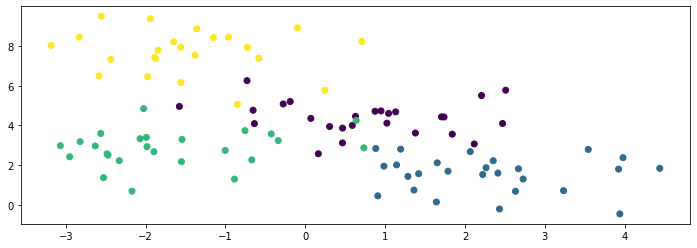

In [50]:
plt.scatter(X[:,0], X[:,1], c=y)

We generate another 50 datapoints to be a holdout set. We visualize them below:

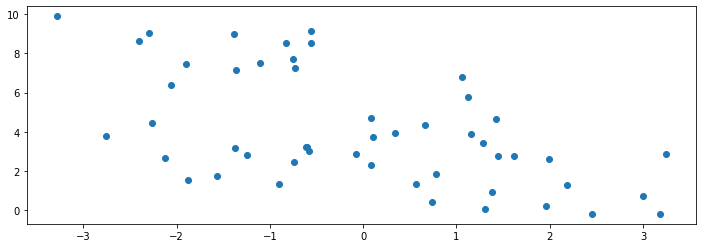

In [51]:
# use the last 50 points as a holdout set
X_holdout, y_holdout = X_all[100:], y_all[100:]
plt.scatter(X_holdout[:,0], X_holdout[:,1])

### 10.4.2.1. Underfitting in Unsupervised Learning

Underfitting happens when we are not able to fully learn the signal hidden in the data.

In the context of GMMs, this means not capturing all the clusters in the data.

Let's fit a GMM on our toy dataset. Below, we define our model to be a mixture of two Gaussians and fit it to the training set:

In [52]:
# fit a GMM
from sklearn import mixture
model = mixture.GaussianMixture(n_components=2)
model.fit(X)

GaussianMixture(n_components=2)

The model finds two distinct components in the data, but they fail to capture the true structure.

We can also measure the value of our objective (the log-likelihood) on the training and holdout sets.

Training Set Log-Likelihood (higher is better): -4.09
Holdout Set Log-Likelihood (higher is better): -4.22


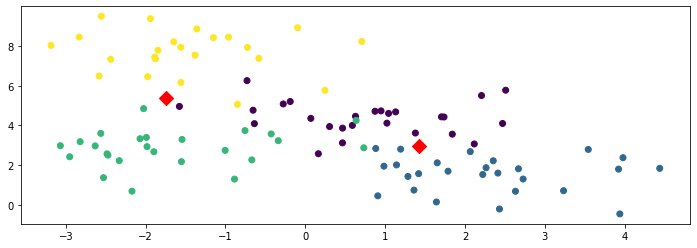

In [53]:
plt.scatter(X[:,0], X[:,1], c=y)
plt.scatter(model.means_[:,0], model.means_[:,1], marker='D', c='r', s=100)
print('Training Set Log-Likelihood (higher is better): %.2f' % model.score(X))
print('Holdout Set Log-Likelihood (higher is better): %.2f' % model.score(X_holdout))

The above figure shows the learned cluster centroids as red diamonds and the training set as colored dots. You can see that the cluster centroids do not represent each class well, i.e., the model is underfitting.

### 10.4.2.2. Overfitting in Unsupervised Learning

Consider now what happens if we further increase the number of clusters.

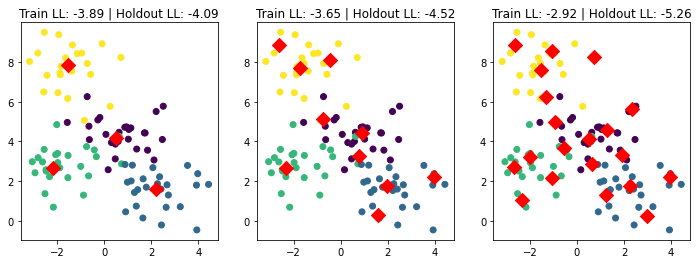

In [54]:
Ks = [4, 10, 20]
f, axes = plt.subplots(1,3)
for k, ax in zip(Ks, axes):
    model = mixture.GaussianMixture(n_components=k)
    model.fit(X)
    ax.scatter(X[:,0], X[:,1], c=y)
    ax.scatter(model.means_[:,0], model.means_[:,1], marker='D', c='r', s=100)
    ax.set_title('Train LL: %.2f | Holdout LL: %.2f' % (model.score(X), model.score(X_holdout)))

In the above figures, we can see that the leftmost figure has the best holdout set's objective value since we define the model to be a mixture of four Gaussians. As we increase the number of clusters, though the training set objective value gets better, the holdout set objective value gets worse; this means we are overfitting.

## 10.4.3. Measuring Generalization Using Log-Likelihood

Probabilistic unsupervised models optimize an objective that can be used to detect overfitting and underfitting by comparing performance between training and holdout sets.

Below, we visualize the performance (measured via negative log-likelihood) on training and holdout sets as $K$ increases.

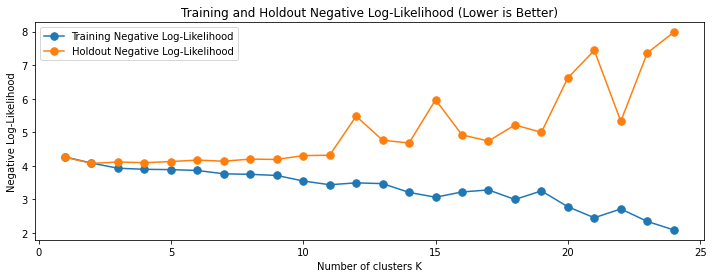

In [56]:
Ks, training_objs, holdout_objs = range(1,25), [], []
for k in Ks:
    model = mixture.GaussianMixture(n_components=k)
    model.fit(X)
    training_objs.append(-model.score(X))
    holdout_objs.append(-model.score(X_holdout))

plt.plot(Ks, training_objs, '.-', markersize=15)
plt.plot(Ks, holdout_objs, '.-', markersize=15)
plt.xlabel("Number of clusters K")
plt.ylabel("Negative Log-Likelihood")
plt.title("Training and Holdout Negative Log-Likelihood (Lower is Better)")
plt.legend(['Training Negative Log-Likelihood', 'Holdout Negative Log-Likelihood'])

The above figure shows that when the number of clusters is below 4, adding more clusters helps reduce both training and holdout sets' negative log-likelihood. Nevertheless, when the number of clusters is above 4, adding more clusters reduces the training set's negative log-likelihood but increases the holdset's negative log-likelihood. The former situation represents underfitting -- you can make the model perform better on both training and holdout sets by making the model more expressive. The latter situation represents overfitting -- making the model more expressive makes the performance on the holdout set worse.

__Warning__: This process doesn't work as well as in supervised learning

For example, detecting overfitting with larger datasets will be paradoxically harder (try it!)

## 10.4.4. Summary

Generalization is important for supervised and unsupervised learning. In this section, we talk about generalization in GMMs (unsupervised learning). The takeaways are:

* A probabilistic model can detect overfitting by comparing the likelihood of training data vs. that of holdout data.

* We can reduce overfitting by making the model less expressive.